In [1]:
import torch
from basic_transformer import QuantileTransformer, QuantileConvDecoderOnlyTransformer
import attention as ATTN

model = QuantileTransformer(
    d_in=2,
    n_quantiles=3,
    emb_size=20,
    n_heads=4,
    n_hidden=32,
    ffn_n_hidden=20,
    num_layers=1,
    _attention=ATTN.DotProductAttention(),
    norm_first=True
)

x = torch.randn(32, 192, 1)
y = torch.randn(32, 192, 1)

model(x, y).shape

torch.Size([32, 192, 3])

In [10]:
model.transformer_blocks[0].mha.attn_weights.shape

torch.Size([32, 4, 192, 192])

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

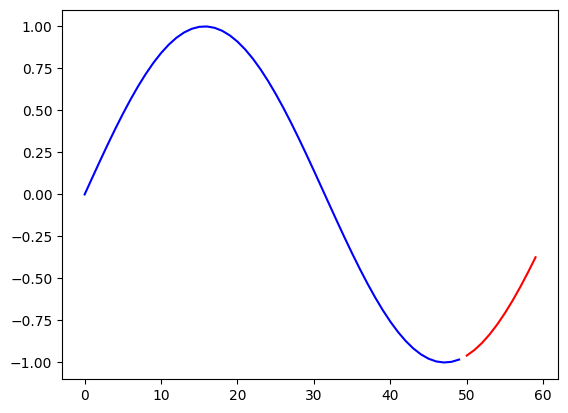

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from synthetic_datasets import SineSyntheticDataset

dataset = SineSyntheticDataset(
    len_timeseries=5000,
    seq_len=50,
    shift=10,
    alpha=0.1
)

src_x, src_y, tgt_x, tgt_y = dataset[0]


plt.plot(src_x.numpy(), src_y.numpy(), 'b')
plt.plot(tgt_x.numpy(), tgt_y.numpy(), 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [15]:
from torch.utils.data import DataLoader

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(3952, 494, 494, 123, 7, 7)

In [ ]:
lr = 1e-3
EPOCHS = 100

In [16]:
def train_step(model, criterion, train_dataloader, optimizer, mask):
    model.train()
    train_loss = 0
    n = 0
    mask = mask.to(model.device)
    for sample in train_dataloader:
        src_X, src_fX, tgt_X, tgt_fX = (v.to(model.device) for v in sample)
        
        out = model(src_X, src_fX, mask)
        loss = criterion(out, tgt_fX)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * src_X.shape[0]
        n += src_X.shape[0]

    return train_loss / n

from criterions import QuantileLoss
criterion = QuantileLoss({'quantiles': [0.1, 0.5, 0.9]})
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_step(model, criterion, train_dl, optimizer, dataset.mask)

AttributeError: 'dict' object has no attribute 'quantiles'

In [ ]:
from criterions import QuantileLoss

train_history = []
val_history = []

criterion = QuantileLoss({'quantiles': [0.1, 0.5, 0.9]})
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, _ = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}")
        if ES.best_model:
            path = f"../../models/{name}/traffic_{name}_{shift}preds.pth"
            torch.save(ES.best_model.state_dict(), path)
    
    ES(val_loss, model)
    # if ES.early_stop: break

history[name] = (train_history, val_history)

best_model = ES.best_model
best_test_loss, best_test_mape_loss, _ = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)
print(f"Test losses: {best_test_loss=:.4f}\t{best_test_mape_loss=:.4f}")

path = f"../../models/{name}/traffic_{name}_{shift}preds.pth"
torch.save(best_model.state_dict(), path)